## Imports

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
# set random seed
SEED = 321
np.random.seed(SEED)

In [35]:
# acf pacf plots custom function
# plot acf pacf function
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [36]:
# check for stationarity - import custom function
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [48]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



# (Core) Preparing Time Series from Wide-Form Data

## Part 1

### Load in the Zillow Home Value Index dataframe.

In [2]:
# import data
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv")
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22462,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,NaN,NaN,...,198490.0,198467.0,196420.0,192002.0,191634.0,189383.0,191134.0,191343.0,192384.0,192110.0
22463,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,NaN,NaN,...,229251.0,232984.0,238245.0,240154.0,242470.0,243119.0,249098.0,255572.0,261910.0,264685.0
22464,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,53380.0,53662.0,...,132490.0,134951.0,137470.0,137430.0,137413.0,137615.0,138908.0,140096.0,141573.0,142438.0
22465,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,258191.0,261607.0,264571.0,266255.0


In [3]:
# check for nulls
df.isna().sum().sum()

1754072

In [4]:
# fill null values
df = df.fillna(method='ffill')

In [5]:
# check again for nulls
df.isna().sum().sum()

1

In [6]:
# fill null values
df = df.fillna(method='bfill')

In [7]:
# check again for nulls
df.isna().sum().sum()

0

### Filter the 4 largest cities into a new dataframe.

Tip: the "SizeRank" column has already ranked the cities by size. The larger the city, the smaller the rank value.
Therefore the 4 largest cities would have rank values of [0,1,2,3]

In [8]:
# create new df with filtered data
df_four = df.head(4)

# preview new df
df_four

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


### Melt the data to long-form and prepare it for time series analysis.

In [9]:
# melt data to long-form
melted = pd.melt(df_four.drop(columns=['RegionID','SizeRank','RegionType','StateName','State','Metro','CountyName']), id_vars=['RegionName'], value_name='Value',var_name="Date")

# preview melted df
melted

,RegionName,Date,Value
0,New York,2000-01-31,253690.0
1,Los Angeles,2000-01-31,234181.0
2,Houston,2000-01-31,109068.0
3,Chicago,2000-01-31,166139.0
4,New York,2000-02-29,255517.0
...,...,...,...
1087,Chicago,2022-08-31,315587.0
1088,New York,2022-09-30,781622.0
1089,Los Angeles,2022-09-30,966595.0
1090,Houston,2022-09-30,272639.0


### Convert the melted dates into datetime datatype.

In [10]:
# convert Date column to datetime
melted['Date'] = pd.to_datetime(melted['Date'])

In [11]:
# verify change
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  1092 non-null   object        
 1   Date        1092 non-null   datetime64[ns]
 2   Value       1092 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.7+ KB


### Make the datetime column the index.

In [12]:
# set Date as index
melted = melted.set_index("Date")

# verify change
melted

,RegionName,Value
Date,,
2000-01-31,New York,253690.0
2000-01-31,Los Angeles,234181.0
2000-01-31,Houston,109068.0
2000-01-31,Chicago,166139.0
2000-02-29,New York,255517.0
...,...,...
2022-08-31,Chicago,315587.0
2022-09-30,New York,781622.0
2022-09-30,Los Angeles,966595.0


### Resample the dataframe as monthly frequency, grouped by City.

In [13]:
# use groupby by city and resample by month
df_four_ts = melted.groupby('RegionName').resample("M").sum()

# verify changes
df_four_ts

C:\Users\eliud\AppData\Local\Temp\ipykernel_6584\976740907.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_four_ts = melted.groupby('RegionName').resample("M").sum()
C:\Users\eliud\AppData\Local\Temp\ipykernel_6584\976740907.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_four_ts = melted.groupby('RegionName').resample("M").sum()
C:\Users\eliud\AppData\Local\Temp\ipykernel_6584\976740907.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which sho

Value
RegionName Date                
Chicago    2000-01-31  166139.0
           2000-02-29  166536.0
           2000-03-31  167368.0
           2000-04-30  168826.0
           2000-05-31  170499.0
...                         ...
New York   2022-05-31  768797.0
           2022-06-30  773944.0
           2022-07-31  777692.0
           2022-08-31  779960.0
           2022-09-30  781622.0

[1092 rows x 1 columns]

## Part 2

### Plot the home values for all 4 cities. (Hint: use unstack)
Make sure to add a title and axis labels.

In [14]:
unstacked_df = df_four_ts.unstack(level=0)
unstacked_df

Value                                
RegionName   Chicago   Houston Los Angeles  New York
Date                                                
2000-01-31  166139.0  109068.0    234181.0  253690.0
2000-02-29  166536.0  109079.0    234401.0  255517.0
2000-03-31  167368.0  108878.0    235513.0  257207.0
2000-04-30  168826.0  108881.0    237589.0  260310.0
2000-05-31  170499.0  108834.0    240113.0  263204.0
...              ...       ...         ...       ...
2022-05-31  312487.0  265558.0    990391.0  768797.0
2022-06-30  314663.0  268901.0    992337.0  773944.0
2022-07-31  315910.0  271059.0    992630.0  777692.0
2022-08-31  315587.0  272400.0    978196.0  779960.0
2022-09-30  315429.0  272639.0    966595.0  781622.0

[273 rows x 4 columns]

### Reformat the y-axis ticks to use thousands of dollars with a "K" at the end. (e.g. "200K, 400K, etc")
Hint: use the FuncFormatter from matplotlib.

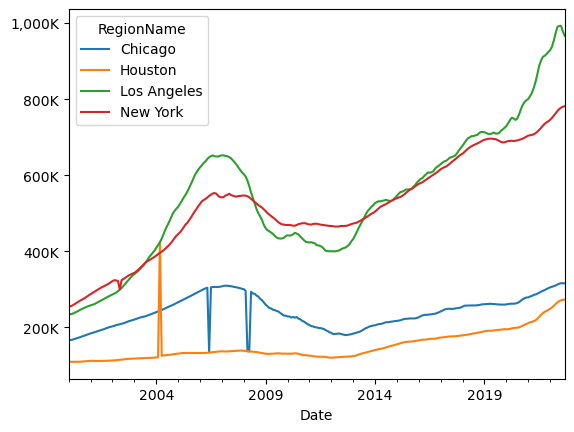

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks

str_fmt = mticks.StrMethodFormatter("{x:,.0f}")

# thousands function for use with FuncFormatter
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"

# create formatter
fmt_thous = mticks.FuncFormatter(thousands)

ax = unstacked_df['Value'].plot()

ax.yaxis.set_major_formatter(fmt_thous)

### Answer the following 2 questions using pandas:

#### 1) Which City had the highest Typical Home Value at the end of 2008? Which had the least?
Hint: You can use the unstacked dataframe or use pd.IndexSlice with the multiindex.

Most: New York

Least: Houston

In [16]:
df_four_ts = df_four_ts.loc[pd.IndexSlice[:, '2008'],:]
df_four_ts

Value
RegionName  Date                
Chicago     2008-01-31  300207.0
            2008-02-29  296063.0
            2008-03-31  136795.0
            2008-04-30  136628.0
            2008-05-31  293467.0
            2008-06-30  288495.0
            2008-07-31  288174.0
            2008-08-31  283199.0
            2008-09-30  280695.0
            2008-10-31  274849.0
            2008-11-30  271059.0
            2008-12-31  265306.0
Houston     2008-01-31  138208.0
            2008-02-29  137512.0
            2008-03-31  136795.0
            2008-04-30  136628.0
            2008-05-31  136228.0
            2008-06-30  135773.0
            2008-07-31  135392.0
            2008-08-31  134770.0
            2008-09-30  133932.0
            2008-10-31  133189.0
            2008-11-30  132247.0
            2008-12-31  131283.0
Los Angeles 2008-01-31  603029.0
            2008-02-29  596635.0
            2008-03-31  586065.0
            2008-04-30  571226.0
            2008-05-31  554589.0
            2008-06-30  539622.0
            2008-07-31  524220.0
            2008-08-31  510520.0
            2008-09-30  500124.0
            2008-10-31  490979.0
            2008-11-30  481905.0
            2008-12-31  469294.0
New York    2008-01-31  546538.0
            2008-02-29  546098.0
            2008-03-31  544562.0
            2008-04-30  541865.0
            2008-05-31  537685.0
            2008-06-30  533810.0
            2008-07-31  529211.0
            2008-08-31  525290.0
            2008-09-30  521347.0
            2008-10-31  518048.0
            2008-11-30  514767.0
            2008-12-31  510309.0

#### 2) How much did the home values change from November 2008 to December 2008 (in dollars)?
Hint: you can use .diff() to calculate the change in values

Chicago: -5753

Houston: -964

Los Angeles: -12611

New York: -4458

In [17]:
df_four_ts_diff = df_four_ts.loc[pd.IndexSlice[:, '2008-11':'2008-12'],:]
df_four_ts_diff

Value
RegionName  Date                
Chicago     2008-11-30  271059.0
            2008-12-31  265306.0
Houston     2008-11-30  132247.0
            2008-12-31  131283.0
Los Angeles 2008-11-30  481905.0
            2008-12-31  469294.0
New York    2008-11-30  514767.0
            2008-12-31  510309.0

In [18]:
diff_nov_dec = df_four_ts_diff.diff()

diff_nov_dec

Value
RegionName  Date                
Chicago     2008-11-30       NaN
            2008-12-31   -5753.0
Houston     2008-11-30 -133059.0
            2008-12-31    -964.0
Los Angeles 2008-11-30  350622.0
            2008-12-31  -12611.0
New York    2008-11-30   45473.0
            2008-12-31   -4458.0

# (Core) Gridsearch SARIMA Models

In [19]:
df_gs = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv')

In [20]:
df_gs.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


## Time Series Models for Home Values

### Filter the dataset only to include values starting in 2018

In [21]:
# melt and drop unnecessary columns
df_gs_melted = pd.melt(df_gs.drop(columns=['RegionID','SizeRank','RegionType','StateName','State','Metro','CountyName']), id_vars=['RegionName'], value_name='Value',var_name="Date")

In [22]:
# preview data
df_gs_melted.head()

,RegionName,Date,Value
0,New York,2000-01-31,253690.0
1,Los Angeles,2000-01-31,234181.0
2,Houston,2000-01-31,109068.0
3,Chicago,2000-01-31,166139.0
4,San Antonio,2000-01-31,114794.0


In [23]:
# drop all cities besides New York
df_gs_ny = df_gs_melted.loc[df_gs_melted['RegionName'] == 'New York']

In [24]:
# preview data
df_gs_ny.head()

,RegionName,Date,Value
0,New York,2000-01-31,253690.0
22467,New York,2000-02-29,255517.0
44934,New York,2000-03-31,257207.0
67401,New York,2000-04-30,260310.0
89868,New York,2000-05-31,263204.0


In [63]:
# change RegionName column name to City
df_gs_ny.rename(columns = {'RegionName':'City'}, inplace = True)

In [65]:
# set Date as datetime and index

# convert Date column to datetime
df_gs_ny['Date'] = pd.to_datetime(df_gs_ny['Date'])
# set Date as index
df_gs_ny = df_gs_ny.set_index("Date")

In [66]:
# preview data
df_gs_ny.head()

,Value
Date,
2018-01-31,656700.0
2018-02-28,661012.0
2018-03-31,665672.0
2018-04-30,669989.0
2018-05-31,673514.0


In [67]:
# filter for 2018 and beyond
df_gs_ny = df_gs_ny.loc['2018':]
df_gs_ny.head()

,Value
Date,
2018-01-31,656700.0
2018-02-28,661012.0
2018-03-31,665672.0
2018-04-30,669989.0
2018-05-31,673514.0


### Check for and address null values.


In [29]:
df_gs_ny.isna().sum()

City     0
Value    0
dtype: int64

In [30]:
# drop city column to allow for decomposition
df_gs_ny = df_gs_ny.drop(columns='City')

In [31]:
# preview data
df_gs_ny.head()

,Value
Date,
2018-01-31,656700.0
2018-02-28,661012.0
2018-03-31,665672.0
2018-04-30,669989.0
2018-05-31,673514.0


### Decompose the Time series to detect seasonality and decide if your model should or should not have a seasonal component


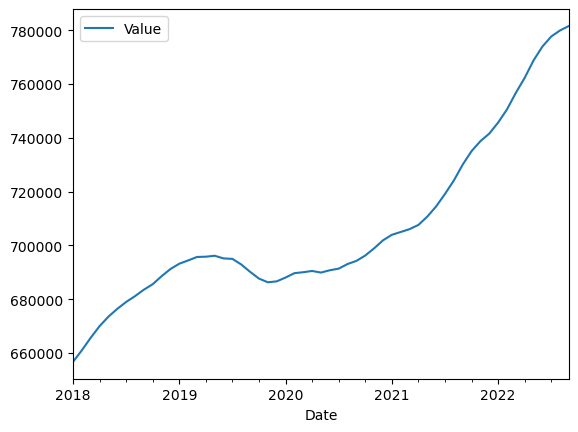

In [32]:
df_gs_ny.plot();

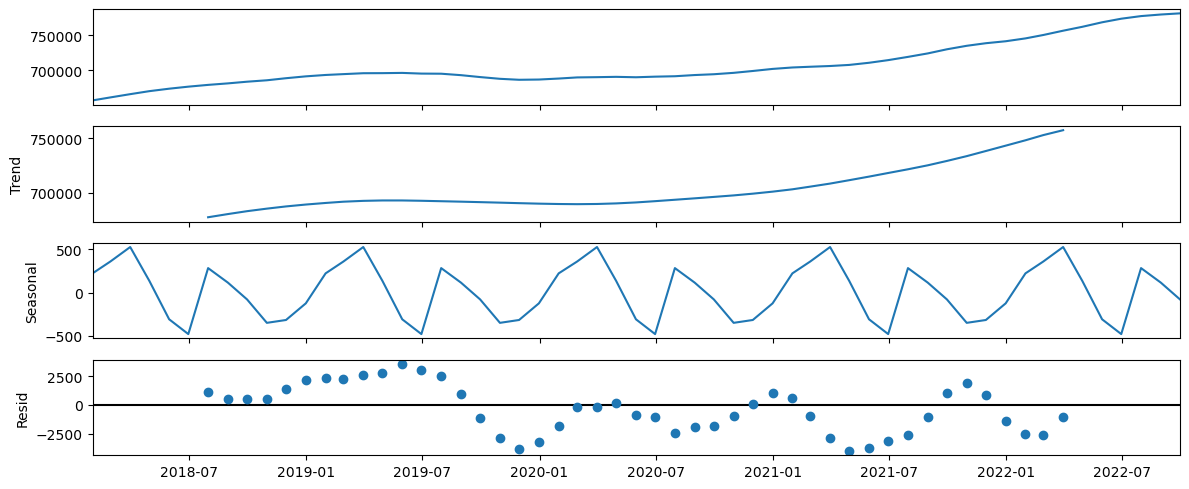

In [33]:
# Apply seasonal decomposition
import statsmodels.tsa.api as tsa
decomp = tsa.seasonal_decompose(df_gs_ny)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

# Is there Seasonality?**********

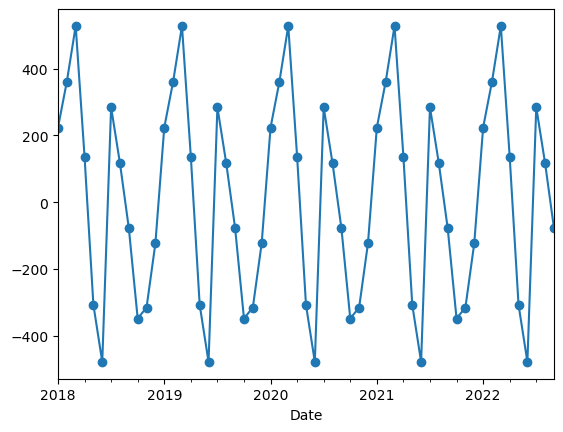

In [111]:
# zoom in on seasonal decomposition
seasonal = decomp.seasonal
ax = seasonal.loc['2018': '2022'].plot(marker = 'o')

# There are 12 points between peaks, indicating a seasonal period of 12 months.

### Determine Time Series Model Orders
#### Check the time series for stationarity.
##### Determine the number of differencing needed to make the data stationary
#### Check the ACF/PACF Plots of the differenced data to determine the orders

In [37]:
# run Ad Fuller Test function
get_adfuller_results(df_gs_ny)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


In [76]:
# determine number of diffs to make stationary using ndiffs
from pmdarima.arima.utils import ndiffs, nsdiffs
d = ndiffs(df_gs_ny)
print(f'd is {d}')

# nsdiffs for D
D = nsdiffs(df_gs_ny, m = 12)
print (f'D = {D}')

d is 2
D = 0


In [108]:
# diff twice
ts_diff2 = df_gs_ny.diff().diff().dropna()

In [109]:
# verify stationarity
get_adfuller_results(ts_diff2)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-5.461615,2,52,0.000003,0.05,True


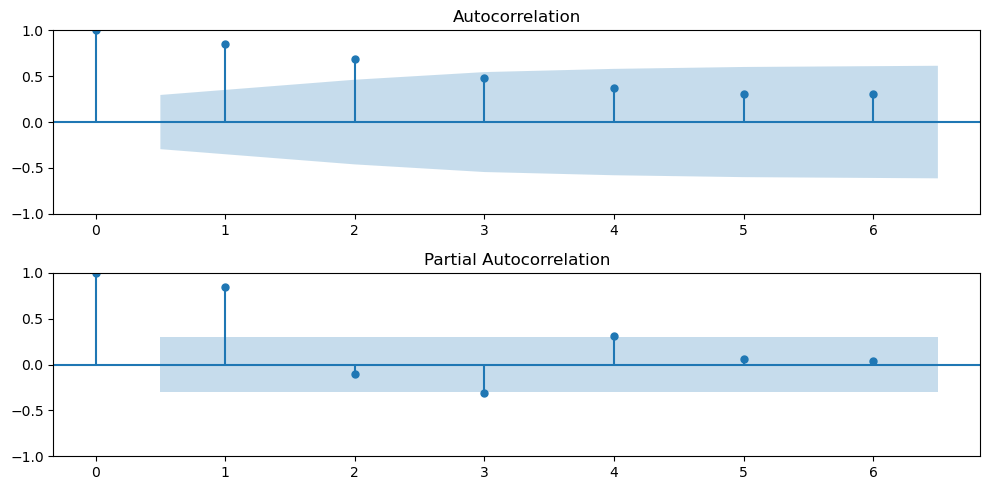

In [106]:
plot_acf_pacf(ts_diff2, annotate_seas=True,nlags = 6, m = 12);

### Split the time series into training and test data (Remember we want to predict 6 months, and our data has been resampled to monthly)


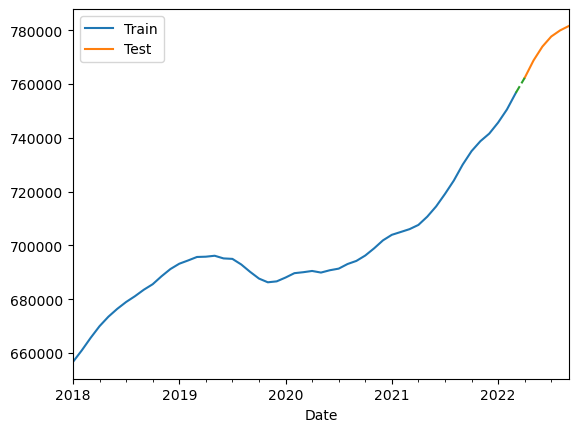

In [94]:
from pmdarima.model_selection import train_test_split

# Calculating number of test lags instead of percentage
n_test_lags = 6

# Modeling to predict 6 months into the future
train, test = train_test_split(df_gs_ny, test_size=n_test_lags)

# store end value of train and start value of test to get connecting line b/w train and test lines
segment = pd.concat([train.tail(1), test.head(1)])
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
segment.plot(ax=ax, linestyle='--')
ax.legend(["Train", "Test"]);

### Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
#### Make forecasts with your model.
#### Plot the forecasts versus the test data
#### Obtain metrics for evaluation

In [100]:
# ns orders: acf =  pacf =  p, d, 0
# s orders: acf = pacf = 0, D, Q, m = 12

# NS = 2, 2, 0
# S = 0, 0, 1, m = 12

p = 2
d = 2
q = 0

P = 0
D = 0
Q = 0
m = 12

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

sarima.summary()

C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   51
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -402.112
Date:                Wed, 01 Nov 2023   AIC                            810.224
Time:                        09:53:04   BIC                            815.899
Sample:                    01-31-2018   HQIC                           812.377
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0006      0.095     -0.007      0.995      -0.186       0.185
ar.L2          0.0017      0.060      0.029      0.977      -0.115       0.118
sigma2      7.615e+05   2.13e+05      3.582      0.000    3.45e+05    1.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.17   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.28   Prob(JB):                         0.40
Heteroskedasticity (H):               2.06   Skew:                            -0.05
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

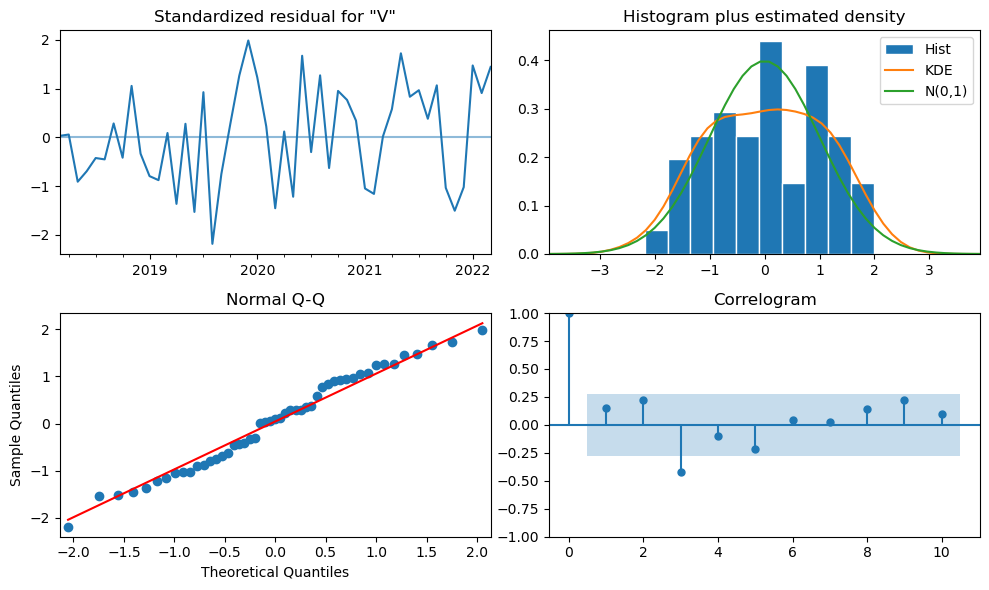

In [101]:
# sarima diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

### Tune with pmdarima's auto_arima
#### Fit a model on training data with the best parameters from auto_arima
#### Obtain metrics for evaluation
#### Make forecasts with the auto_arima model
#### Plot the forecasts versus the test data

In [45]:
# use auto_arima (gridsearch) instead of for loop as we did in previous lesson
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=6,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=808.438, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=810.919, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=811.112, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=806.526, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[6] intercept   : AIC=810.304, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=810.188, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[6] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=809.251, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[6] intercept   : AIC=809.683, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[6] intercept   : AIC=811.354, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[6]          
Total fit time: 1.037 seconds


In [46]:
print(auto_model.order)
print(auto_model.seasonal_order)

(0, 0, 0)
(0, 0, 0, 6)


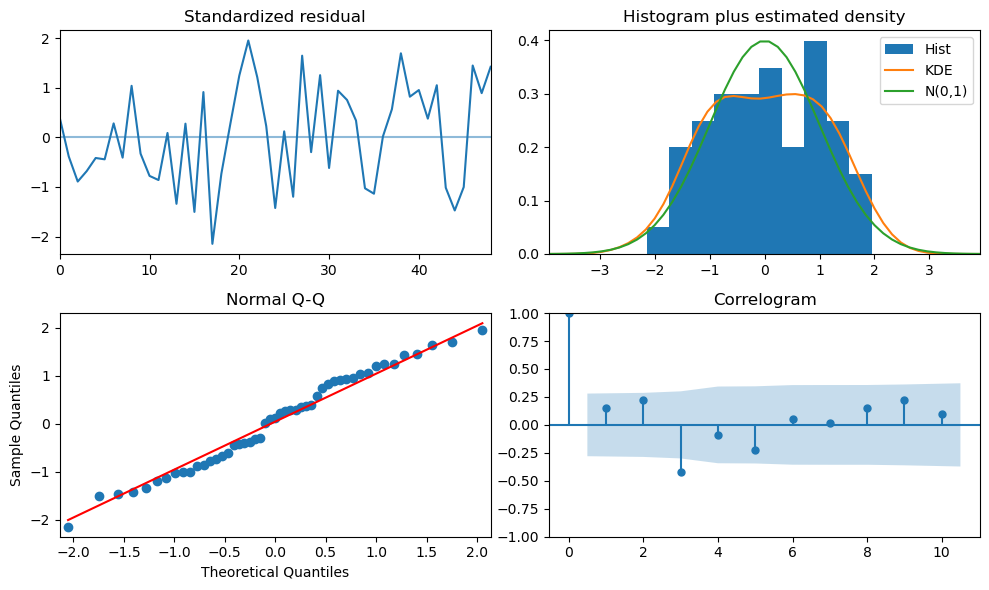

In [47]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\eliud\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,070.422
- MSE = 1,290,316.598
- RMSE = 1,135.921
- R^2 = -0.921
- MAPE = 102.78%


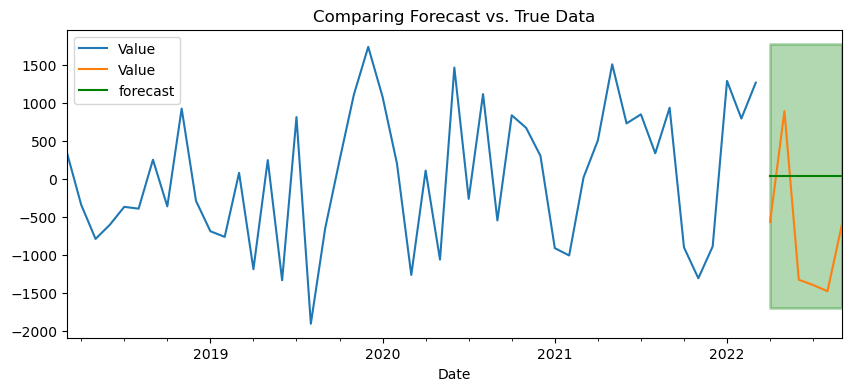

In [50]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

### Select your final model


In [51]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   49
Model:                          ARIMA   Log Likelihood                -402.219
Date:                Wed, 01 Nov 2023   AIC                            808.439
Time:                        09:18:40   BIC                            812.222
Sample:                    03-31-2018   HQIC                           809.874
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.6327    126.671      0.297      0.766    -210.637     285.902
sigma2      7.871e+05   2.21e+05      3.560      0.000    3.54e+05    1.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.27   Prob(JB):                         0.38
Heteroskedasticity (H):               1.84   Skew:                            -0.05
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make true future forecasts using the entire dataset (for dates beyond the entire ts).
#### Calculate the predicted net change in home value for the forecasted period as both:
##### Raw values for change in the final month in the forecast vs. the first month.
##### Convert the raw delta into a percent change.

Answer the following questions in a Markdown cell

1 - What is the predicted home value in New York City 6 months into the future (beyond the dataset)?

2 - What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?